In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from ast import literal_eval
import json
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
import pickle
from sklearn.linear_model import LinearRegression
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

%matplotlib inline
# plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost'

POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'vegas'
POSTGRES_PASSWORD = 'VrichCrich99'
POSTGRES_DBNAME = 'univers'

In [3]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)

<h2 style='color: red; font-size: 2em'>Fetch user data according to data count</h2>

In [4]:
appstech_labs_id = 1 # user id for fetching

In [5]:
# define a fetching function according to the appstech_labs_user data size
def fetch_data(_id, small_data_size, medium_data_size, large_data_size):
    return pd.read_sql_query(f"SELECT * FROM user_sales_table WHERE appstech_labs_id='{appstech_labs_id}'", cnx, index_col='txn_date', parse_dates=['txn_date'])  

In [6]:
df = fetch_data(appstech_labs_id, small_data_size=530234, medium_data_size=1530234, large_data_size=2203234)
df.index = pd.to_datetime(df.index)
df.head()

,id,appstech_labs_id,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,customer_id,customer_name,company_currency,company_currency_symbol,txn_currency,exchange_rate,source,sales_type,gross_amount,gross_cost,margin,due_date
txn_date,,,,,,,,,,,,,,,,,,
2020-05-17,1,1,0.0,0.00,0.0,0.0,4,Diego Rodriguez,USD,$,USD,1.0,quickbooks,sale,140.00,0.0,140.00,2020-05-17
2020-05-19,2,1,10.0,8.75,0.0,0.0,15,Pye's Cakes,USD,$,USD,1.0,quickbooks,sale,78.75,0.0,78.75,2020-05-19
2020-04-26,3,1,0.0,0.00,0.0,0.0,14,Kate Whelan,USD,$,USD,1.0,quickbooks,sale,225.00,0.0,225.00,2020-04-26
2020-05-16,4,1,0.0,0.00,0.0,0.0,6,Dylan Sollfrank,USD,$,USD,1.0,quickbooks,sale,337.50,0.0,337.50,2020-05-16
2020-05-19,5,1,0.0,0.00,0.0,0.0,15,Pye's Cakes,USD,$,USD,1.0,quickbooks,refund,-87.50,0.0,0.00,2020-05-19


<h2 style='color: red; font-size: 2em'>Feature Engineering</h2>

In [7]:
def get_all_numeric_features(df):
    numeric_feats = df.dtypes[df.dtypes != 'object'].index
    numeric_feats = numeric_feats[1:]
    return numeric_feats

numeric_feats = get_all_numeric_features(df)
numeric_feats = numeric_feats[:-1]
numeric_feats

Index(['appstech_labs_id', 'discount_rate', 'discount_amount',
       'sales_tax_rate', 'sales_tax_amount', 'exchange_rate', 'gross_amount',
       'gross_cost', 'margin'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2020-05-17 to 2020-05-04
Data columns (total 18 columns):
id                         36 non-null int64
appstech_labs_id           36 non-null int64
discount_rate              36 non-null float64
discount_amount            36 non-null float64
sales_tax_rate             36 non-null float64
sales_tax_amount           36 non-null float64
customer_id                36 non-null object
customer_name              36 non-null object
company_currency           36 non-null object
company_currency_symbol    36 non-null object
txn_currency               36 non-null object
exchange_rate              36 non-null float64
source                     36 non-null object
sales_type                 36 non-null object
gross_amount               36 non-null float64
gross_cost                 36 non-null float64
margin                     36 non-null float64
due_date                   36 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(

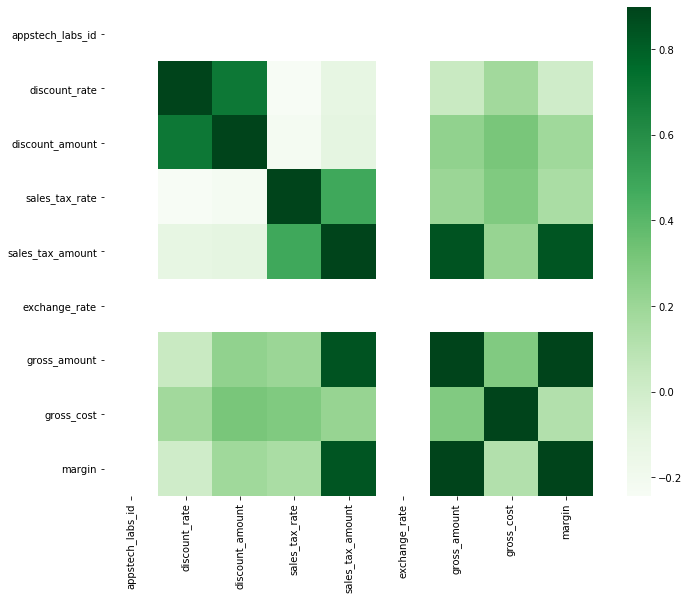

In [9]:
cormat = df[numeric_feats].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=0.9, square=True, cmap='Greens')
plt.show()

<h2 style='color: red; font-size: 2em'>Feature Importance</h2>

In [10]:
# feature importance
def feature_importance(features, df, threshold, *args, **kwargs):
    '''args, kwargs pass True or include=True for additional features'''
    important_feature = list()
    cormat = df[features].corr()
    
    if kwargs.get('include') or args:
        if kwargs.get('include') or args[0]:
            include = ['qty', 'margin']
            for expt in include:
                important_feature.append(expt)
    
    for feat in features:
        if cormat[f"{feat}"][-3] > threshold:
            important_feature.append(feat)
            
    return important_feature


In [11]:
imp_features = feature_importance(numeric_feats, df, 0.69, False)
df_feats = df.copy()
df_feats = df_feats[imp_features]
df_feats.head()

,sales_tax_amount,gross_amount,margin
txn_date,,,
2020-05-17,0.0,140.00,140.00
2020-05-19,0.0,78.75,78.75
2020-04-26,0.0,225.00,225.00
2020-05-16,0.0,337.50,337.50
2020-05-19,0.0,-87.50,0.00


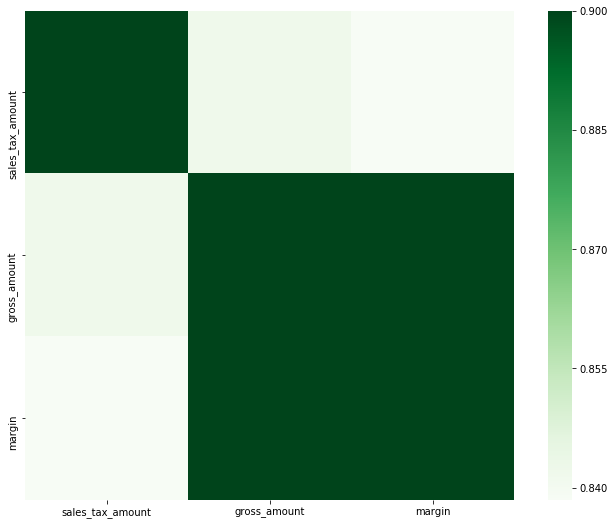

In [12]:
cormat = df_feats[imp_features].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=0.9, square=True, cmap='Greens')
plt.show()

<h2 style='color: red; font-size: 2em'>Check For Null Values</h2>

In [13]:
def generate_null_values(df, labels, target, model):
    data_with_null = df[labels].dropna()
    data_without_null = data_with_null.dropna()
    
    # all features except target
    train_data_x = data_without_null.drop(target, axis=1).values
    train_data_y = data_without_null[f"{target}"].values.reshape(-1, 1)
    
    model.fit(X=train_data_x, y=train_data_y) # training the model

    test_data = data_with_null.drop(target, axis=1) #
    yhat = model.predict(test_data)
        
    newdf = pd.DataFrame(yhat, columns=[target])
    # replace only the null values
    data_with_null[target].fillna(newdf[target], inplace=True)
    
    return data_with_null[target]
    
    
def handle_missing_value(df, features, *args, **kwargs):
    linreg = LinearRegression()
    
    if kwargs.get('drop_column'):
        return df.drop(features, axis=1)
    
    for feat in features:
        null_count = df[feat].isnull().sum()
        
        if null_count > 1 and null_count < int(len(df[feat]) * 10 / 100): # full missing values with mean()
            if df[feat].dtype == 'object':
                df[feat] = df[feat].fillna(df[feat].mode())
            else:
                df[feat] = df[feat].fillna(df[feat].mean())
            
        elif null_count >= int(len(df[feat]) * 10 / 100) and null_count < int(len(df[feat]) * 20 / 100): # random generate missing values
            technique = [df[feat].fillna(df[feat].mean()), df[feat].fillna(df[feat].median()), df[feat].fillna(df[feat].mode())]
            index = np.random.choice([0, 1, 2], p=[0.34, 0.33, 0.33])
            df[feat] = technique[index]
            
        elif null_count >= int(len(df[feat]) * 20 / 100) and null_count < int(len(df[feat]) * 40 / 100): # predict missing values if selected else random generate
            if kwargs.get('use_model') or args:
                if kwargs.get('use_model') or args[0]:
                    generate_null = generate_null_values(df, features, feat, linreg)
                    df[feat] = generate_null[~generate_null.index.duplicated()]
            else:
                technique = [df[feat].fillna(df[feat].mean()), df[feat].fillna(df[feat].median()), df[feat].fillna(df[feat].mode())]
                index = np.random.choice([0, 1, 2], p=[0.34, 0.33, 0.33])
                df[feat] = technique[index]
        
        elif null_count >= int(len(df[feat]) * 40 / 100): # worst case senario
            df = df.drop(feat, axis=1)
    
    return df


In [14]:
df_feats = handle_missing_value(df_feats, imp_features, True)
df_feats.isnull().sum()

sales_tax_amount    0
gross_amount        0
margin              0
dtype: int64

<h2 style='color: red; font-size: 2em'>Target Engineering</h2>

In [15]:
# handle outliers
def handleOutliers(df, threshold):    
    z = np.abs(zscore(df))
    
    return df[(z < threshold).all(axis=1)]

In [16]:
df_feats_outliers = handleOutliers(df_feats, 3)
print(df_feats_outliers.shape)
df_feats_outliers.head()

(35, 3)


,sales_tax_amount,gross_amount,margin
txn_date,,,
2020-05-17,0.0,140.00,140.00
2020-05-19,0.0,78.75,78.75
2020-04-26,0.0,225.00,225.00
2020-05-16,0.0,337.50,337.50
2020-05-19,0.0,-87.50,0.00


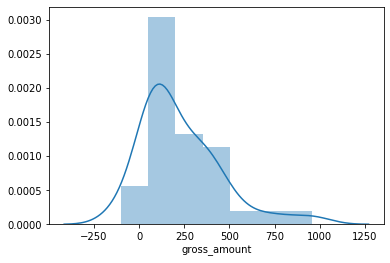

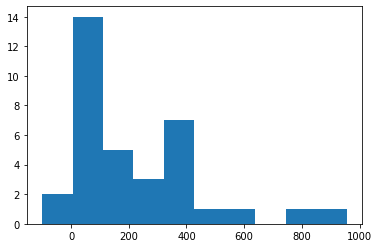

In [17]:
sns.distplot(df_feats_outliers['gross_amount'])
plt.show()
plt.hist(df_feats_outliers['gross_amount'])
plt.show()

In [18]:
df_feats_outliers.head()

,sales_tax_amount,gross_amount,margin
txn_date,,,
2020-05-17,0.0,140.00,140.00
2020-05-19,0.0,78.75,78.75
2020-04-26,0.0,225.00,225.00
2020-05-16,0.0,337.50,337.50
2020-05-19,0.0,-87.50,0.00


In [19]:
new_df = df_feats_outliers.copy()
new_df = new_df

new_df = new_df.rename_axis('ds')
new_df = new_df.rename(columns={'gross_amount': 'y'})
new_df = new_df.drop(['sales_tax_amount', 'margin'], axis=1)
new_df = new_df.reset_index()
new_df.head()

,ds,y
0,2020-05-17,140.00
1,2020-05-19,78.75
2,2020-04-26,225.00
3,2020-05-16,337.50
4,2020-05-19,-87.50


In [20]:
new_df.shape

(35, 2)

In [21]:
fb_train = new_df[:-5]
fb_test = new_df[len(fb_train):]

print(fb_train.shape, fb_test.shape)

(30, 2) (5, 2)


In [22]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [23]:
m = Prophet()
m.fit(fb_train)
future = m.make_future_dataframe(periods=len(fb_test))
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [24]:
# print(fb_test)
# forecast['yhat'][-len(fb_test):]

In [25]:
r2_score(fb_test['y'].values, forecast['yhat'][-len(fb_test):].values)

0.003074133463851658

In [27]:
df_holidays_events = pd.read_csv("data/fcal_Romania_2019.csv", )
df_holidays_events.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 20: invalid start byte

In [ ]:
df_holidays_events.shape

In [ ]:
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
holidays.head()

In [42]:
print(fb_test.shape, fb_train.shape)

(5, 2) (30, 2)


In [ ]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.1, holidays=holidays)
m.add_seasonality(name='monthyly', period=5, fourier_order=1)
m.fit(fb_train)
future = m.make_future_dataframe(periods=len(fb_test), )
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [ ]:
r2_score(fb_test['y'].values, forecast['yhat'][-len(fb_test):].values)

In [ ]:
# print(fb_test)
# forecast['yhat'][-len(fb_test):]

In [ ]:
plt.plot(fb_test['y'].values)
plt.plot(forecast['yhat'][-len(fb_test):].values)
plt.show()